In [1]:
import numpy as np  # for numerics (matrix math)
from scipy.sparse import diags  # for numerics (creating diagonal matrix)
from scipy.stats import gaussian_kde  # for numerics (DOS)
import matplotlib.pyplot as plt  # for plotting

# for vector plots:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# $\mathrm{RuO}_2$ layers

In [2]:
basis = ['p_{x,1}', 'p_{y,1}', 'p_{z,1}',
         'p_{x,2}', 'p_{y,2}', 'p_{z,2}',
         'd_{z^2}', 'd_{x^2-y^2}', 'd_{xy}', 'd_{yz}', 'd_{xz}']
n_basis = len(basis)

In [3]:
def make_H_kxky(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp):
    # diagonal
    eg = [d0 + 6*Dq - 2*Ds - 6*Dt,
          d0 + 6*Dq + 2*Ds - Dt]
    t2g = [d0 - 4*Dq + 2*Ds - Dt,
           d0 - 4*Dq - Ds + 4*Dt,
           d0 - 4*Dq - Ds + 4*Dt]
    H0 = diags(6*[p0] + eg + t2g).todense()
    
    def f(k):
        kx = k[..., 0]
        ky = k[..., 1]
        
        k_shape = k.shape[:-1]
        H = np.repeat(H0.A[np.newaxis, :, :], np.prod(k_shape), axis=0).reshape(*(k_shape + H0.shape))
        
        # overlaps
        sinxh = np.sin(kx/2)
        sinyh = np.sin(ky/2)
        cosxhyh = np.cos(kx/2) * np.cos(ky/2)
        sinxhyh = sinxh * sinyh
        s3 = np.sqrt(3)
        H[..., 3, 0] =  2 * (pps + ppp) * cosxhyh
        H[..., 4, 0] = -2 * (pps - ppp) * sinxhyh
        H[..., 3, 1] = -2 * (pps - ppp) * sinxhyh
        H[..., 4, 1] =  2 * (pps + ppp) * cosxhyh
        H[..., 5, 2] =  4 * ppp * cosxhyh
        H[..., 6, 0] = -1 * pds * sinxh
        H[..., 7, 0] = s3 * pds * sinxh
        H[..., 8, 1] = 2 * pdp * sinxh
        H[..., 10, 2] = -2 * pdp * sinxh
        H[..., 8, 3] = 2 * pdp * sinyh
        H[..., 6, 4] = -1 * pds * sinyh
        H[..., 7, 4] = -s3 * pds * sinyh
        H[..., 9, 5] = -2 * pdp * sinyh
        return H
    return f

In [4]:
n_k = 100
k_mesh_grid = np.mgrid[0:np.pi:n_k*1j, 0:np.pi:n_k*1j]
k_mesh = k_mesh_grid.reshape(2,-1).T
k_mesh_red = k_mesh[k_mesh[:, 0] <= k_mesh[:, 1]]
print(len(k_mesh), len(k_mesh_red))

10000 5050


In [5]:
p0, pps, ppp = -4.41, 0.7, -0.3
d0, Dq, Ds, Dt = -0.41, 0.1, -0.05, 0.
pds, pdp = -2.4, 1.0

In [6]:
H = make_H_kxky(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp)
Hmesh = H(k_mesh_red)

In [7]:
ew, ev = np.linalg.eigh(Hmesh)

In [8]:
xrange = np.linspace(-10, 10, 1000)
dos = gaussian_kde(ew.flat, 0.01).pdf(xrange)

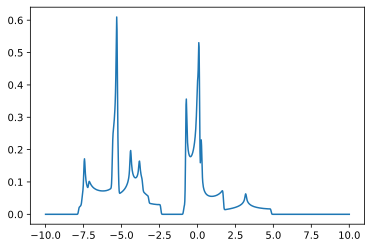

In [9]:
plt.plot(xrange, dos)

In [10]:
pdos = []
for i in range(n_basis):
    print(i, end=' ')
    weights = np.abs(ev[:, i])**2
    p = gaussian_kde(ew.flat, 0.01, weights=weights.flat).pdf(xrange)
    pdos.append(p)

0 1 2 3 4 5 6 7 8 9 10 

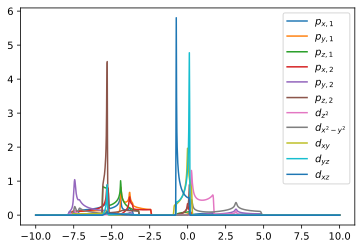

In [11]:
for i, p in enumerate(pdos):
    plt.plot(xrange, p, label='$'+basis[i]+'$')
plt.legend()

In [12]:
k_path = np.vstack([np.linspace((0,0),(1,0),100),
                    np.linspace((1,0),(1,1),100),
                    np.linspace((1,1),(0,0),int(np.sqrt(2)*100)),
                  ])
k_path *= np.pi

ew_path = np.linalg.eigvalsh(H(k_path))

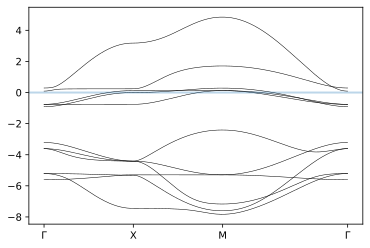

In [13]:
plt.plot(ew_path, color='k', lw=0.5)
plt.xticks([0, 100, 200, len(k_path)-1], ['$\Gamma$', 'X', 'M', '$\Gamma$'])
plt.axhline(alpha=0.3, lw=2)

In [14]:
from ipywidgets import interact, FloatSlider

def solve_plot_symmpath(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp):
    H = make_H_kxky(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp)
    ew_path = np.linalg.eigvalsh(H(k_path))
    plt.plot(ew_path, color='k', lw=0.5, )
    plt.xticks([0, 100, 200, len(k_path)-1], ['$\Gamma$', 'X', 'M', '$\Gamma$'])
    plt.axhline(alpha=0.3, lw=2)

params = {
'p0': FloatSlider(-4.41, min=-7, max=-2, continuous_update=False),
'd0': FloatSlider(-0.41, min=-1, max=0, continuous_update=False),
'Dq': FloatSlider(0.1, min=-0.5, max=0.5, continuous_update=False),
'Ds': FloatSlider(-0.05, min=-0.2, max=0.0, continuous_update=False),
'Dt': FloatSlider(0.0, min=-0.1, max=0.1, continuous_update=False),
'pps': FloatSlider(0.7,  min=-2, max=2, continuous_update=False),
'ppp': FloatSlider(-0.3, min=-1, max=1, continuous_update=False),
'pds': FloatSlider(-2.4, min=-4, max=1, continuous_update=False),
'pdp': FloatSlider(1.0, min=-1, max=3, continuous_update=False),
}

interact(solve_plot_symmpath, **params)

interactive(children=(FloatSlider(value=-4.41, continuous_update=False, description='p0', max=-2.0, min=-7.0),…

<function __main__.solve_plot_symmpath(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp)>

([], [])

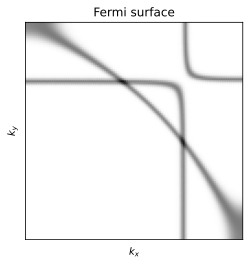

In [15]:
ew = np.linalg.eigvalsh(H(k_mesh_grid.T))
fermiweight = np.exp(-ew**2 / 0.0001).sum(axis=-1)
#plt.imshow(fermiweight, cmap='gist_yarg')
xi, yi = k_mesh_grid
plt.pcolormesh(xi, yi, fermiweight, cmap='gist_yarg', shading='gouraud', rasterized=True)
plt.title('Fermi surface')
plt.xlabel('$k_x$'); plt.ylabel('$k_y$'); plt.gca().set_aspect(1); plt.xticks([]); plt.yticks([])

([], [])

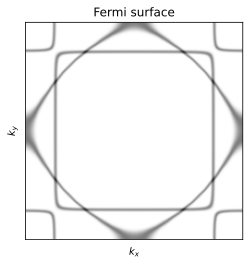

In [16]:
#xi_full = np.block([[-np.flip(xi), -np.flip(xi)], [xi, xi]])
#yi_full = np.block([[-np.flip(yi), yi], [-np.flip(yi), yi]])
full_fmap = np.block([[np.flip(fermiweight), np.flip(fermiweight, axis=0)], [np.flip(fermiweight, axis=1), fermiweight]])
#plt.pcolormesh(xi_full, yi_full, full_fmap, cmap='gist_yarg')
plt.imshow(full_fmap, cmap='gist_yarg')
plt.title('Fermi surface')
plt.xlabel('$k_x$'); plt.ylabel('$k_y$'); plt.gca().set_aspect(1); plt.xticks([]); plt.yticks([])

In [17]:
def solve_plot_fs(Ds):
    H = make_H_kxky(p0, d0, Dq, Ds, Dt, pps, ppp, pds, pdp)
    ew = np.linalg.eigvalsh(H(k_mesh_grid.T))
    fermiweight = np.exp(-ew**2 / 0.0001).sum(axis=-1)
    full_fmap = np.block([[np.flip(fermiweight), np.flip(fermiweight, axis=0)], [np.flip(fermiweight, axis=1), fermiweight]])
    #plt.pcolormesh(xi_full, yi_full, full_fmap, cmap='gist_yarg')
    plt.imshow(full_fmap, cmap='gist_yarg')
    plt.title(f'Fermi surface\n$Ds={Ds}$')
    plt.xlabel('$k_x$'); plt.ylabel('$k_y$'); plt.gca().set_aspect(1); plt.xticks([]); plt.yticks([])

interact(solve_plot_fs, Ds=FloatSlider(-0.05, min=-0.2, max=0.0, step=0.01, continuous_update=False))

interactive(children=(FloatSlider(value=-0.05, continuous_update=False, description='Ds', max=0.0, min=-0.2, s…

<function __main__.solve_plot_fs(Ds)>